Next, we will annotate the cell types:

In [1]:
suppressPackageStartupMessages({
    library(Seurat, quietly = T)
    library(HGNChelper, quietly = T)
    
    library(dplyr, quietly = T)
    library(openxlsx, quietly = T)
    library(reshape2, quietly = T)
    
    library(ggplot2, quietly = T)
    library(RColorBrewer, quietly = T)
})

data_path_0B = '/data3/hratch/STAT4/'
data_path = '/data3/hratch/STAT4_v2/'
sctype_path = '/data2/hratch/Software/'

# Automated Annotation

Automatically annotate each cluster based on markers using ScType (http://session.asuscomm.com/sctype_docs/index.html#benefits)

According the the GitHub tutorial, you can used the scaled, integrated counts matrix as input

First, I cloned the github repo (commit ID 36e298c49a57846c8de3f8d1ee58f753d3a9a2a0) into /data2/hratch/Software: 

In [2]:
# git clone git@github.com:IanevskiAleksandr/sc-type.git --> commit ID 36e298c49a57846c8de3f8d1ee58f753d3a9a2a0

In [3]:
pbmc.integrated<-readRDS(file = paste0(data_path, 'interim/pbmc_integrated.RDS'))
md<-pbmc.integrated@meta.data

In [4]:
# load sc-type functions from locally cloned repo (ensures consistency with version)

source(paste0(sctype_path, 'sc-type/', 'R/gene_sets_prepare.R'))
source(paste0(sctype_path, 'sc-type/', 'R/sctype_score_.R'))       
db_<-paste0(sctype_path, 'sc-type/', 'ScTypeDB_full.xlsx')

# # load from remote      
# source("https://raw.githubusercontent.com/IanevskiAleksandr/sc-type/master/R/gene_sets_prepare.R")
# source("https://raw.githubusercontent.com/IanevskiAleksandr/sc-type/master/R/sctype_score_.R")
# db_ = "https://raw.githubusercontent.com/IanevskiAleksandr/sc-type/master/ScTypeDB_full.xlsx"

In [5]:
tissue = "Immune system" 
# prepare gene sets
suppressWarnings({
    suppressMessages({
        gs_list = gene_sets_prepare(db_, tissue)
    })
})

The PBMCs can be annotated as any of the following cell types:

In [6]:
intersect(names(gs_list$gs_positive), names(gs_list$gs_negative))

[1] "Pro-B cells"                                 
 [2] "Pre-B cells"                                 
 [3] "Naive B cells"                               
 [4] "Memory B cells"                              
 [5] "Plasma B cells"                              
 [6] "Naive CD8+ T cells"                          
 [7] "Naive CD4+ T cells"                          
 [8] "Memory CD8+ T cells"                         
 [9] "Memory CD4+ T cells"                         
[10] "Effector CD8+ T cells"                       
[11] "Effector CD4+ T cells"                       
[12] "γδ-T cells"                                  
[13] "Platelets"                                   
[14] "CD8+ NKT-like cells"                         
[15] "CD4+ NKT-like cells"                         
[16] "Natural killer  cells"                       
[17] "Eosinophils"                                 
[18] "Neutrophils"                                 
[19] "Basophils"                                   
[20] "Mast cells"                                  
[21] "Classical Monocytes"                         
[22] "Non-classical monocytes"                     
[23] "Intermediate monocytes"                      
[24] "Macrophages"                                 
[25] "Megakaryocyte"                               
[26] "Endothelial"                                 
[27] "Erythroid-like and erythroid precursor cells"
[28] "HSC/MPP cells"                               
[29] "Progenitor cells"                            
[30] "Myeloid Dendritic cells"                     
[31] "Plasmacytoid Dendritic cells"                
[32] "Granulocytes"                                
[33] "ISG expressing immune cells"                 
[34] "Cancer cells"

In [7]:

       
# get cell-type by cell matrix (scores each cell for each cell type)
es.max = sctype_score(scRNAseqData = pbmc.integrated@assays$integrated@scale.data, 
                      scaled = TRUE, 
                      gs = gs_list$gs_positive, gs2 = gs_list$gs_negative) 

# merge by cluster by taking the sum of the scores of each cell type
cL_resutls = do.call("rbind", lapply(unique(md$seurat_clusters), function(cl){
    es.max.cl = sort(rowSums(es.max[ ,rownames(md[md$seurat_clusters==cl, ])]), decreasing = !0)
    head(data.frame(cluster = cl, type = names(es.max.cl), scores = es.max.cl, ncells = sum(md$seurat_clusters==cl)), 10)
}))

# take max score of each cluster
sctype_scores = cL_resutls %>% group_by(cluster) %>% top_n(n = 1, wt = scores)  
sctype_scores[['freq']]<-100*sctype_scores$ncells/sum(sctype_scores$ncells)
sctype_scores$type[as.numeric(as.character(sctype_scores$scores)) < sctype_scores$ncells/4] = "Unknown"


sctype_scores

cluster,type,scores,ncells,freq
<fct>,<chr>,<dbl>,<int>,<dbl>
1,Classical Monocytes,9411.4308,2351,15.4813644
6,Naive B cells,4444.0289,947,6.2360068
0,Naive CD4+ T cells,4486.4331,3765,24.7925721
7,Natural killer cells,3620.3315,550,3.6217569
4,CD8+ NKT-like cells,3652.6530,1276,8.4024760
3,Naive CD8+ T cells,2317.7779,1328,8.7448966
5,Naive B cells,5221.0587,1123,7.3949691
2,Naive CD4+ T cells,2305.3769,2082,13.7099960
9,γδ-T cells,569.8041,385,2.5352298


In [8]:
# assign cell types to barcodes 
mapper<-setNames(sctype_scores$type, sctype_scores$cluster)
md[['Cell.Type']]<-unlist(unname(mapper[as.character(md$seurat_clusters)]))

co<-c('Naive B cells', 'Naive CD4+ T cells', 'Naive CD8+ T cells', 'γδ-T cells', 'CD8+ NKT-like cells', 'Natural killer  cells', 
 'Plasmacytoid Dendritic cells', 'Classical Monocytes', 'Non-classical monocytes', 'Neutrophils',
  'Erythroid-like and erythroid precursor cells', 'Platelets'
 )
md[['Cell.Type']]<-factor(x = md$Cell.Type,levels = co)
# retain individual barcode scores
md<-cbind(md, t(es.max[, rownames(md)]))
pbmc.integrated@meta.data<-md

Let's see what the distribution of scores was for the annotations:

Using seurat_clusters as id variables



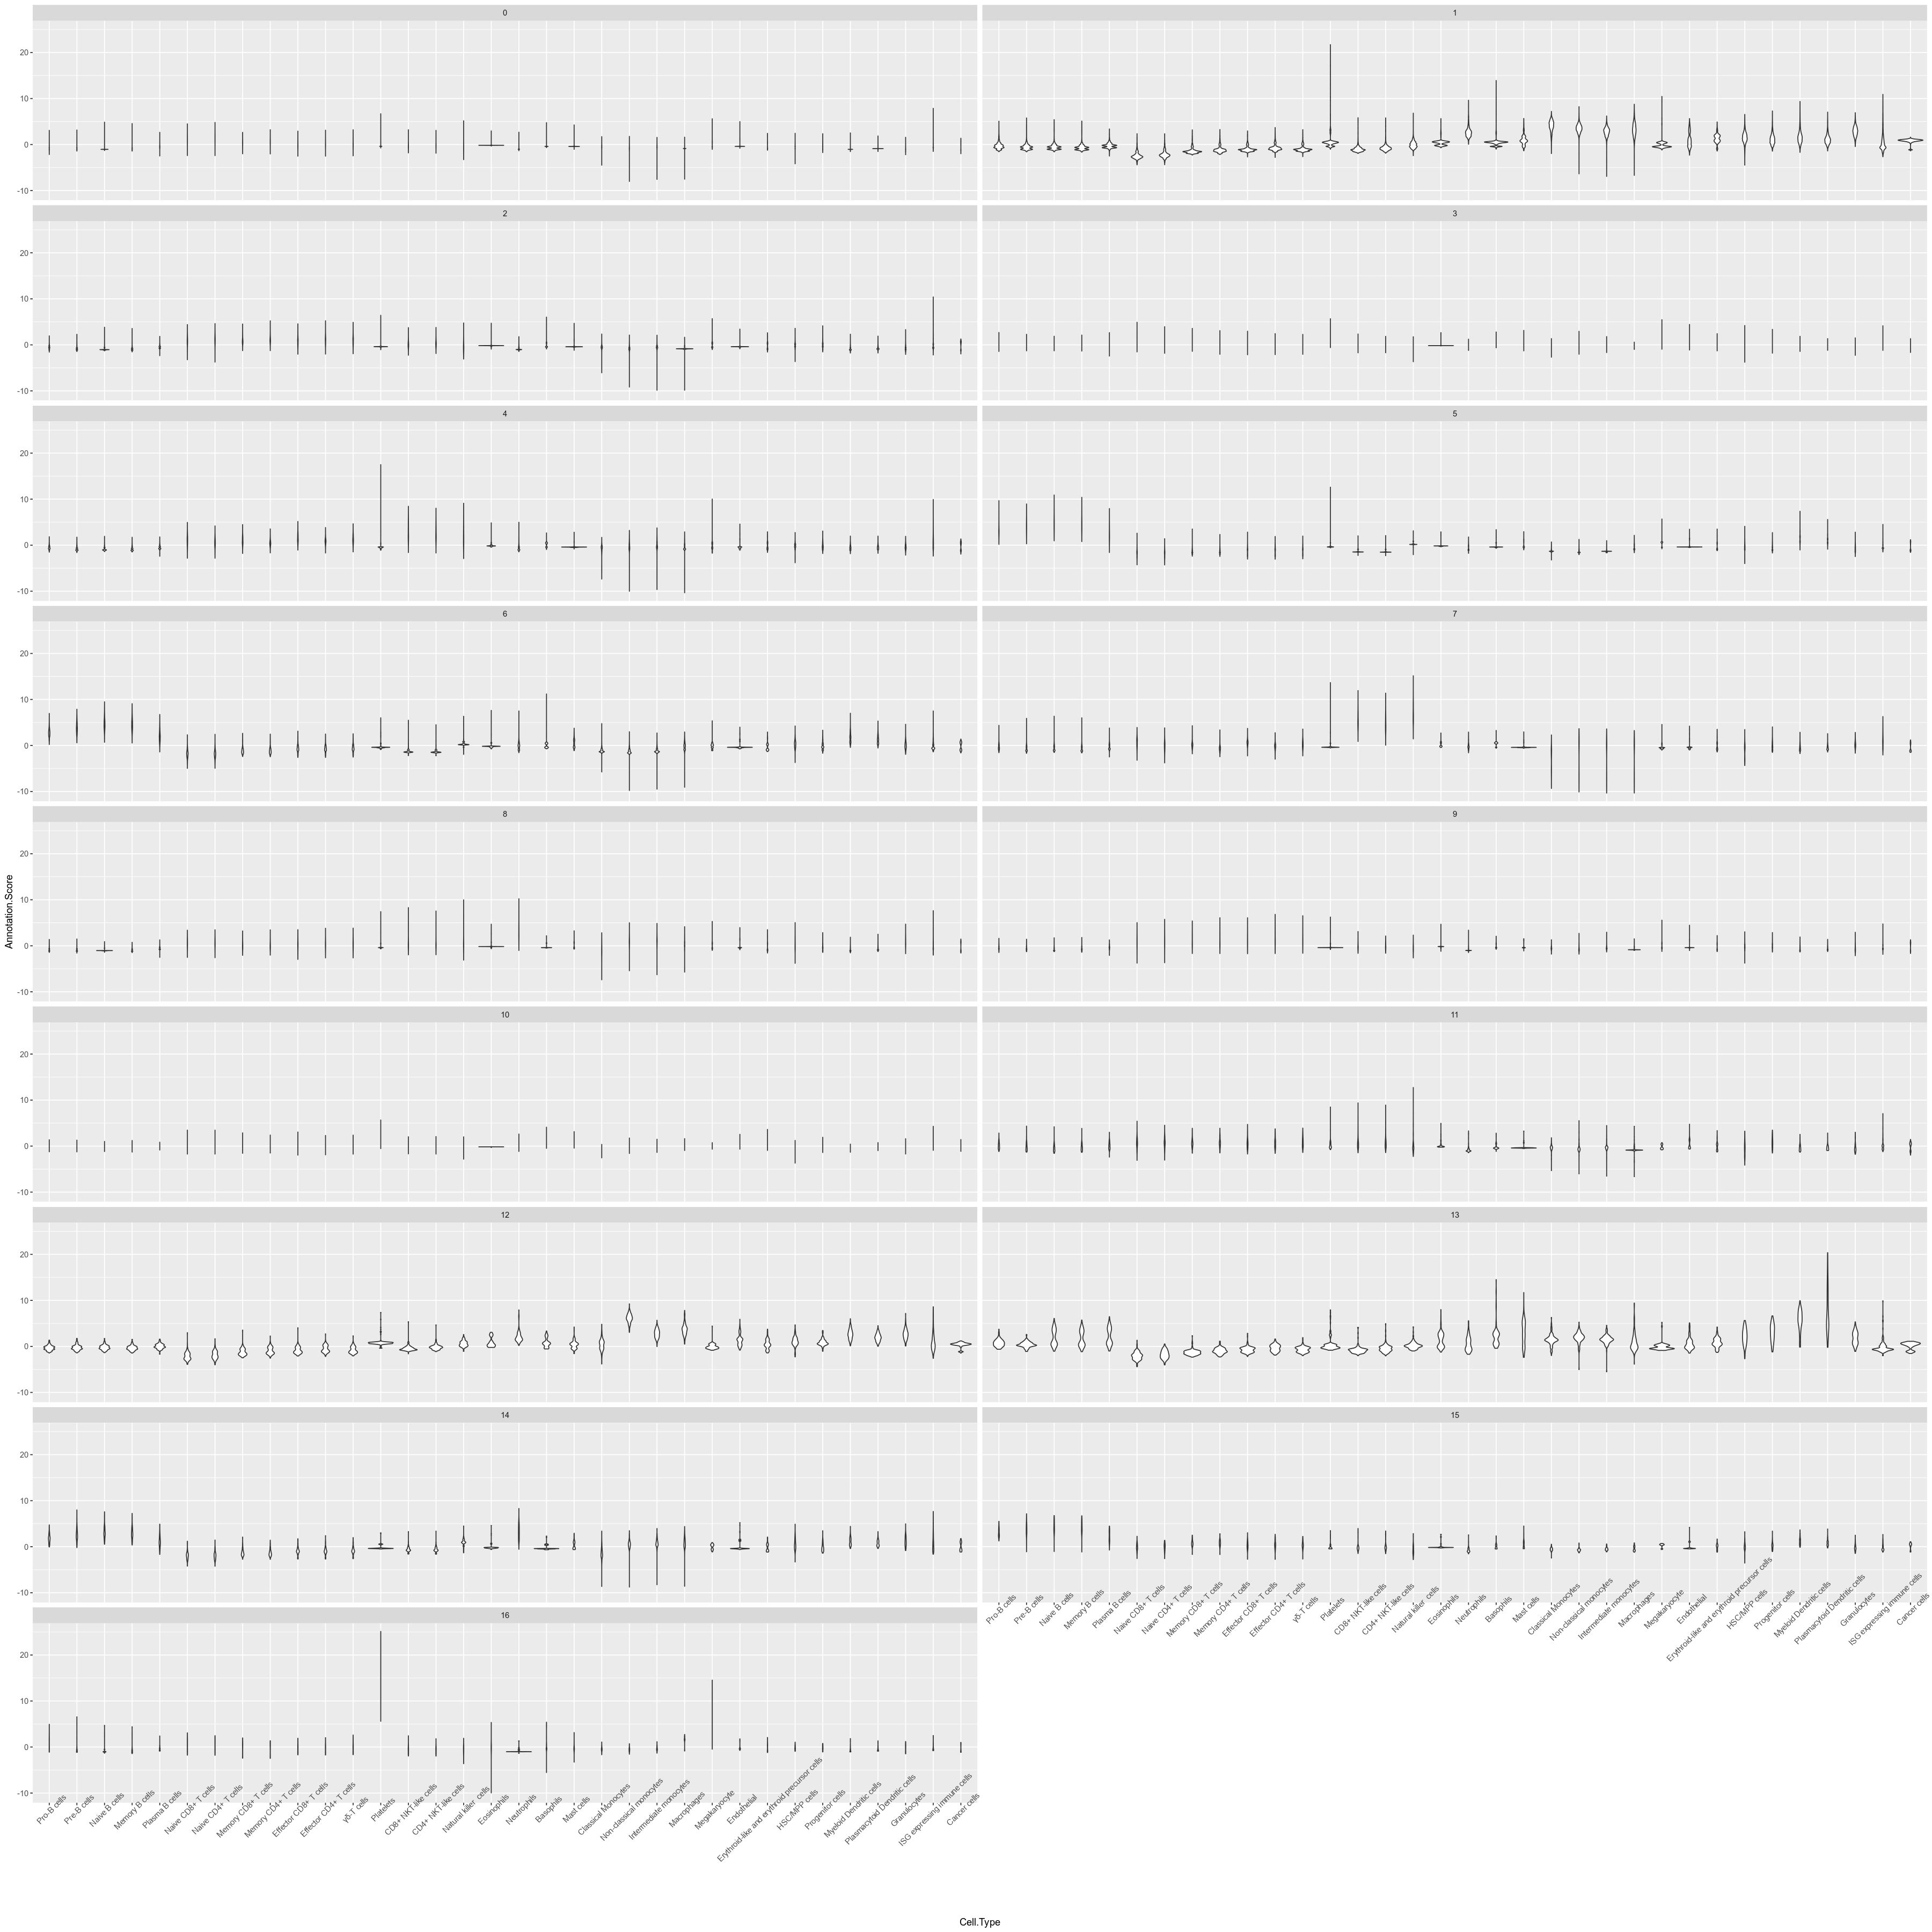

In [9]:
viz.df<-md[!colnames(md) %in% colnames(md)[c(1,2,3,4,5, 7)]]
viz.df<-melt(viz.df, value.name = 'Annotation.Score')
colnames(viz.df)<-c('seurat_clusters', 'Cell.Type', 'Annotation.Score')

h_ = 30
w_ = 30
options(repr.plot.height=h_, repr.plot.width=w_)
g1<-ggplot(data = viz.df, aes(x = Cell.Type, y = Annotation.Score)) + geom_violin() + 
facet_wrap(~seurat_clusters, ncol = 2)+
theme(axis.text.x = element_text(angle = 45))

g1

Let's look at distributions of scores for the cell type that was actually assigned to each cluster:

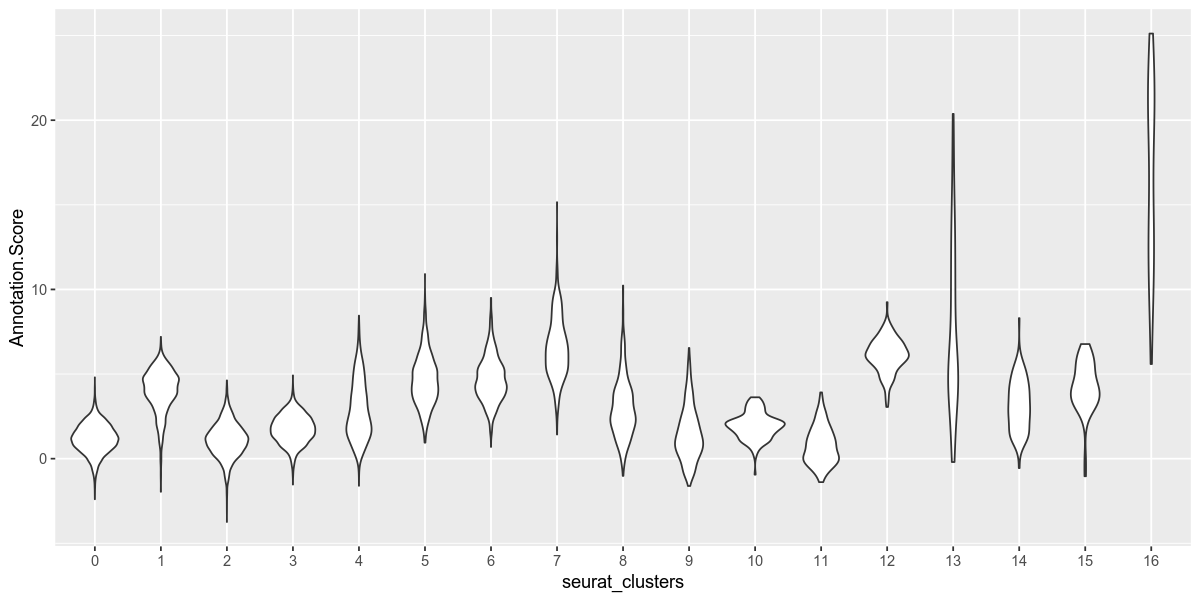

In [10]:
# filter for the score that was assigned
retain.idx<-c()
for (cluster in names(mapper)){
    retain.idx<-c(retain.idx, 
                  rownames(viz.df[(viz.df$seurat_clusters == cluster) & (viz.df$Cell.Type == mapper[cluster]), ]))
}
viz.df<-viz.df[retain.idx,]

h_ = 5
w_ = 10
options(repr.plot.height=h_, repr.plot.width=w_)
g2<-ggplot(data = viz.df, aes(x = seurat_clusters, y = Annotation.Score)) + geom_violin() 

g2

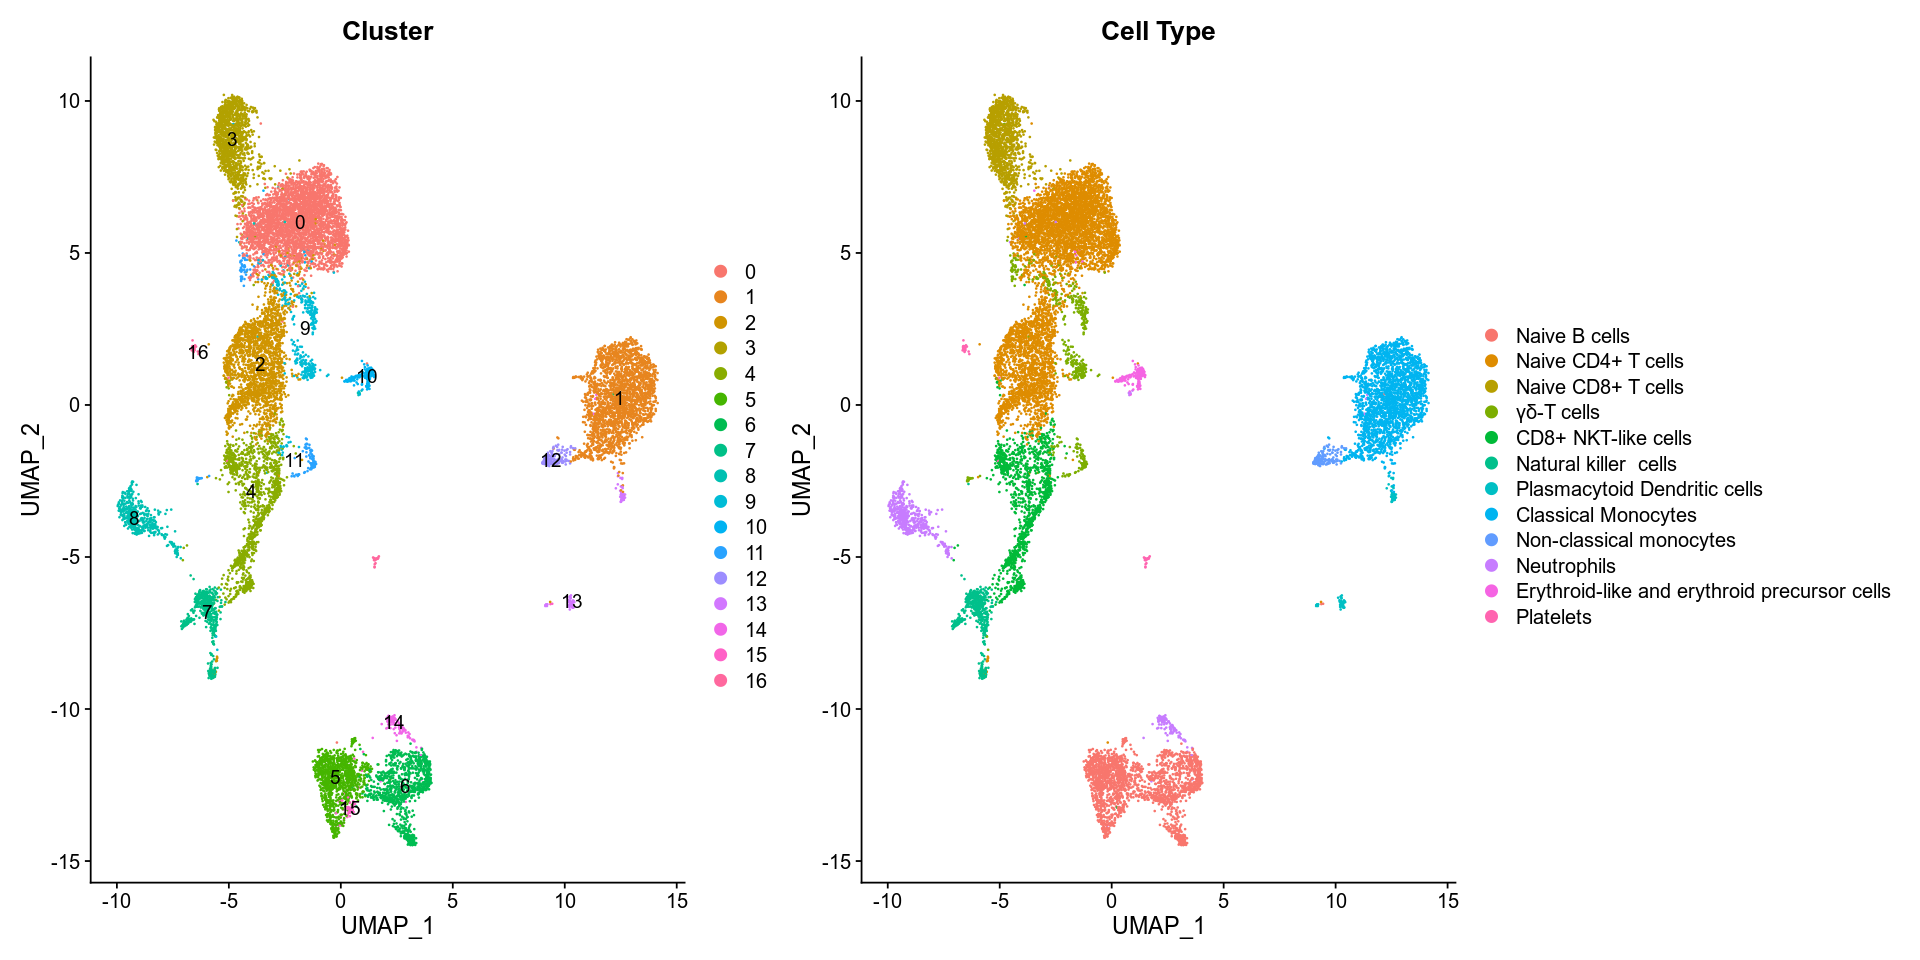

In [11]:
h_ = 8
w_ = 16
options(repr.plot.height=h_, repr.plot.width=w_)
g3a <- DimPlot(pbmc.integrated, reduction = "umap", group.by = "seurat_clusters", shuffle = T, label = T)+
ggtitle('Cluster')
g3c <- DimPlot(pbmc.integrated, reduction = "umap", group.by = "Cell.Type", shuffle = T,  label = F)+
ggtitle('Cell Type')

g3<-g3a + g3c
# for (ext in c('.svg', '.png', '.pdf')){ggsave(paste0(data_path, 'figures/processing/', 
#                                                      'UMAP', ext), g3)}     
g3

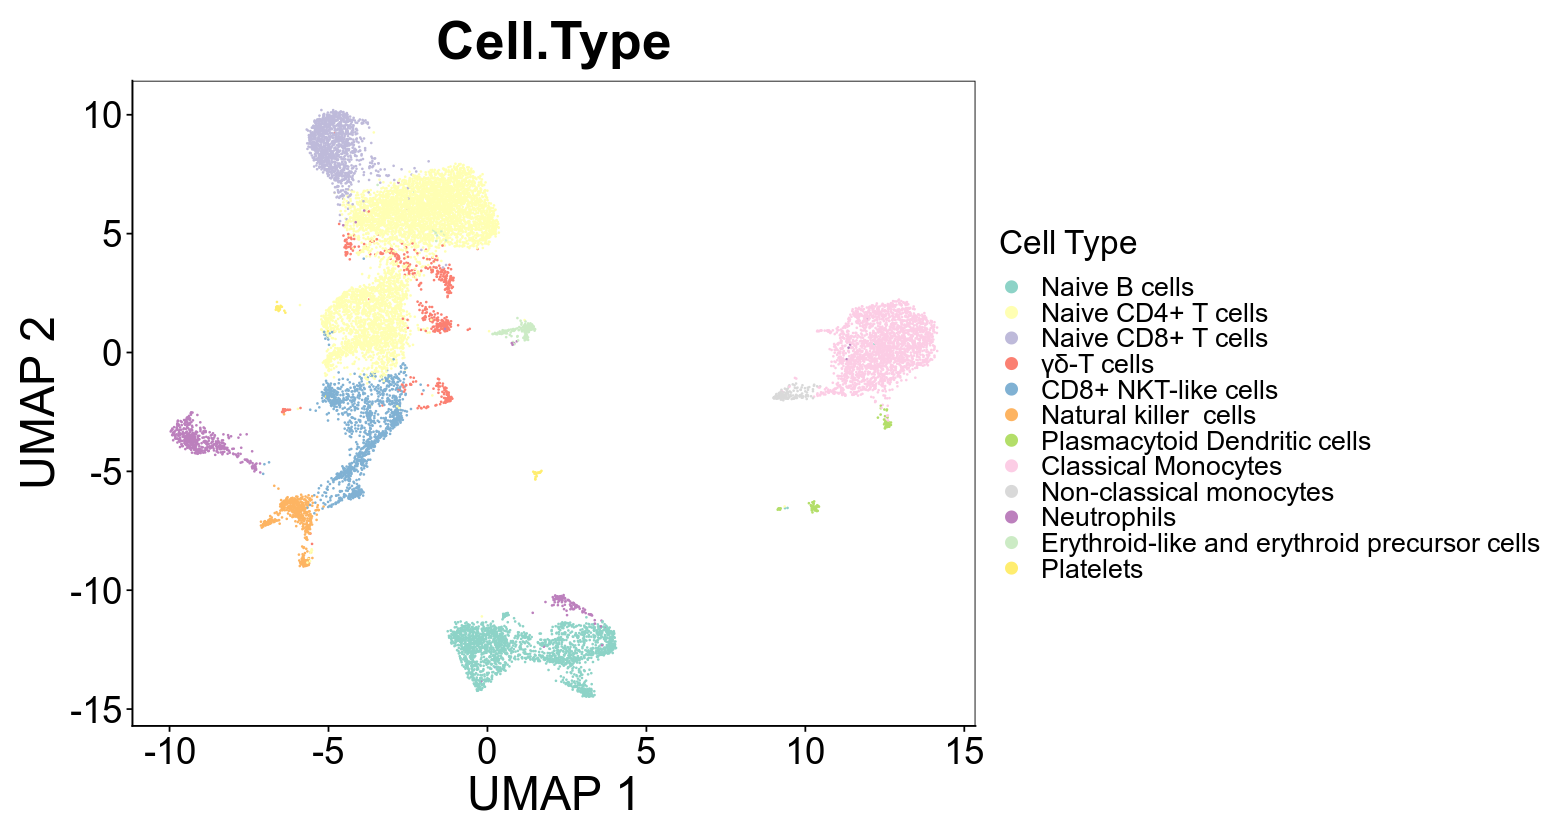

In [12]:
h_ = 7
w_ = 13
options(repr.plot.height=h_, repr.plot.width=w_)

colors = brewer.pal(n=12, "Set3")

theme = theme(panel.background = element_blank(), panel.border = element_rect(colour = 'black', fill = 'NA'),
         text = element_text(size=28), panel.spacing = unit(1.15, "lines"), 
          axis.title=element_text(size=28), legend.text=element_text(size=16), 
         legend.title=element_text(size=20), axis.text.x = element_text(size = 22), 
             axis.text.y = element_text(size = 22)) 

g4<-DimPlot(pbmc.integrated, reduction = 'umap',  
            group.by = 'Cell.Type', label = F)+
    xlab('UMAP 1')+ylab('UMAP 2')+
    scale_color_manual(values = colors, labels = co) + labs(color='Cell Type')+theme
g4

In [13]:
table(md$Cell.Type)


                               Naive B cells 
                                        2127 
                          Naive CD4+ T cells 
                                        5847 
                          Naive CD8+ T cells 
                                        1328 
                                  γδ-T cells 
                                         548 
                         CD8+ NKT-like cells 
                                        1276 
                       Natural killer  cells 
                                         550 
                Plasmacytoid Dendritic cells 
                                         143 
                         Classical Monocytes 
                                        2351 
                     Non-classical monocytes 
                                         157 
                                 Neutrophils 
                                         629 
Erythroid-like and erythroid precursor cells 
                                 

In [14]:
table(md$Cell.Type)/dim(md)[[1]]


                               Naive B cells 
                                 0.140063216 
                          Naive CD4+ T cells 
                                 0.385025682 
                          Naive CD8+ T cells 
                                 0.087448966 
                                  γδ-T cells 
                                 0.036085869 
                         CD8+ NKT-like cells 
                                 0.084024760 
                       Natural killer  cells 
                                 0.036217569 
                Plasmacytoid Dendritic cells 
                                 0.009416568 
                         Classical Monocytes 
                                 0.154813644 
                     Non-classical monocytes 
                                 0.010338470 
                                 Neutrophils 
                                 0.041419729 
Erythroid-like and erythroid precursor cells 
                                 

# DotPlot

Dotplot of each marker to double check that annotated cell types make sense. 

Using Lori's markers:

In [15]:
markers<-read.csv(paste0(data_path_0B, 
                         'raw/pbmc_canonical_markers.csv'))
markers$Cell.Type = factor(x = as.character(markers$Cell.Type), levels = co)
markers<-markers[with(markers, order(Cell.Type)), ]
markers<-unique(unlist(sapply(markers[['Markers.Gene.ID']], function(x) strsplit(as.character(x), ', ')[[1]])))
print(paste0('The total number of unique markers is: ', length(markers)))

markers.present<-intersect(markers, rownames(pbmc.integrated))
print(paste0('The total number of unique markers in the HVGs: ', length(markers.present)))
markers<-rev(markers)

[1] "The total number of unique markers is: 92"
[1] "The total number of unique markers in the HVGs: 50"


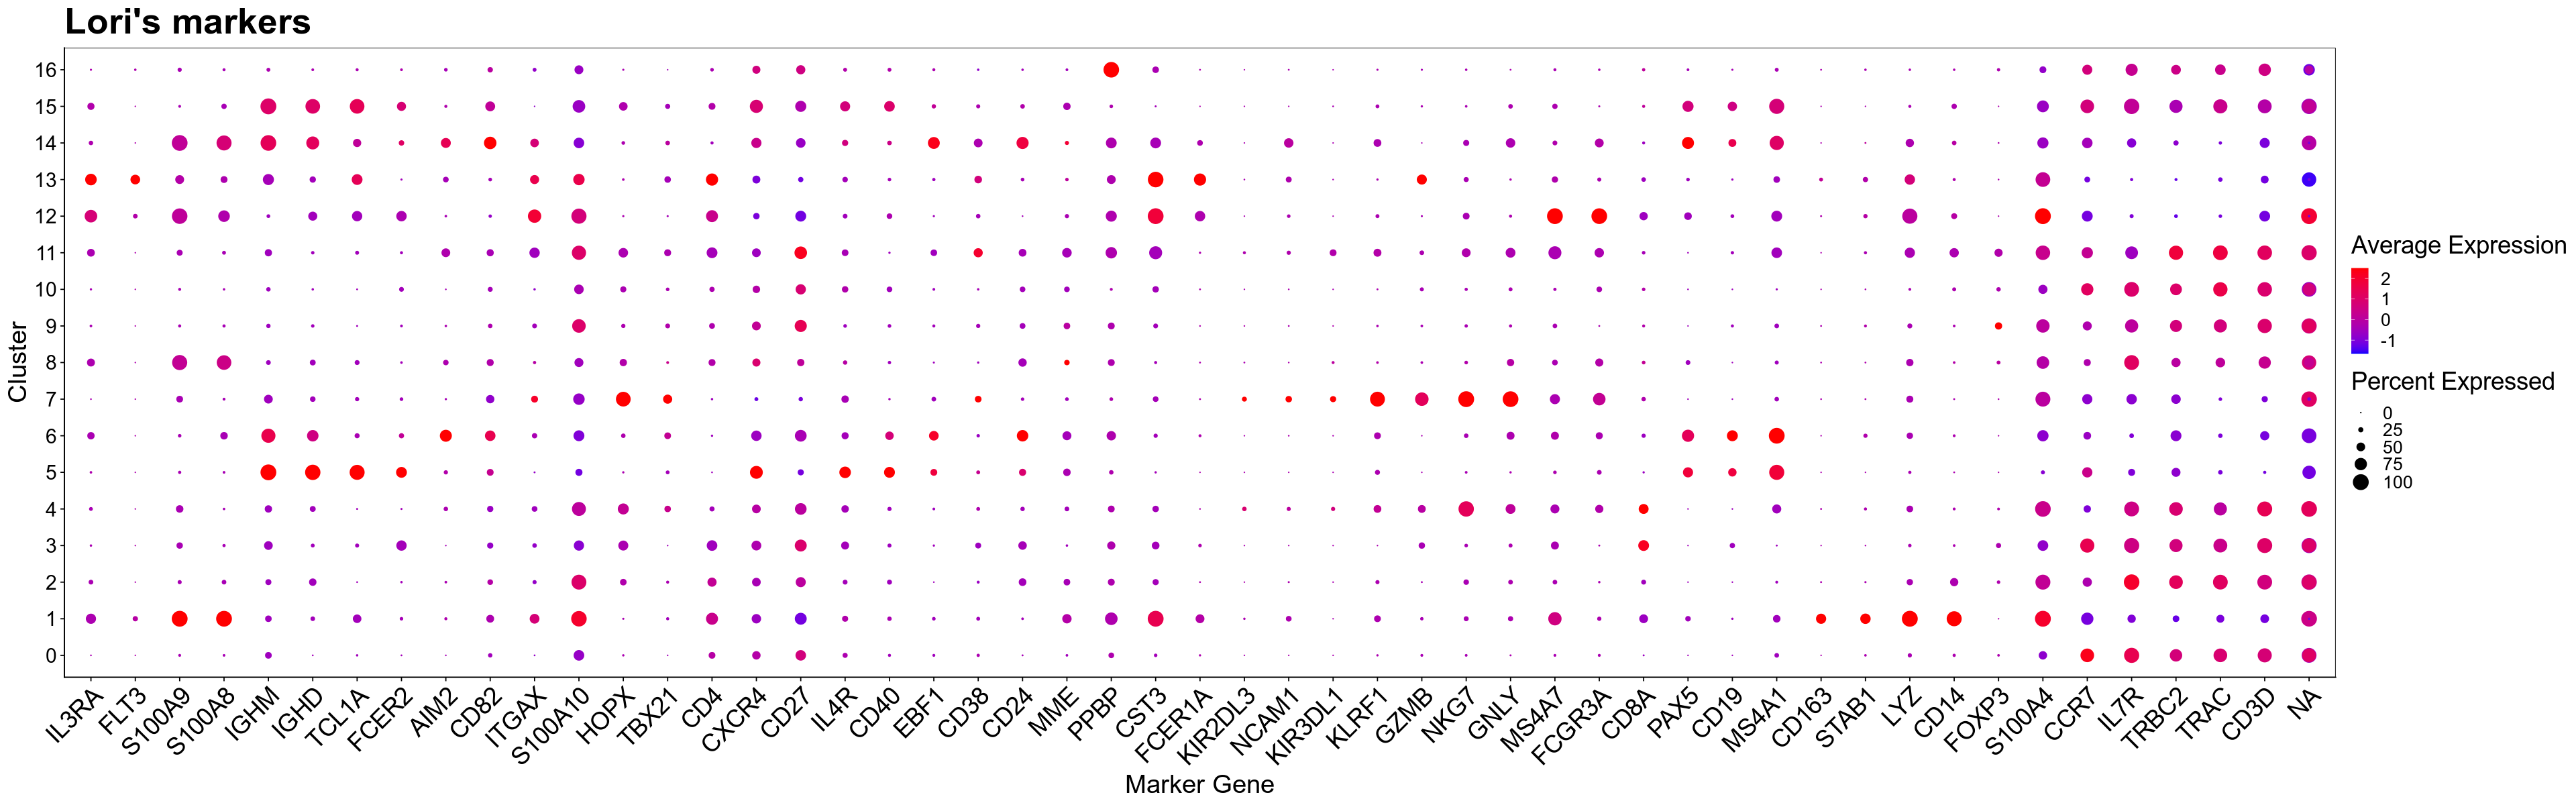

In [16]:
h_ = 10
w_ = 32
options(repr.plot.height=h_, repr.plot.width=w_)

theme = theme(panel.background = element_blank(), 
              panel.border = element_rect(colour = 'black', fill = 'NA'),
         text = element_text(size=28), panel.spacing = unit(1.15, "lines"), 
          axis.title=element_text(size=23), legend.text=element_text(size=16), 
         legend.title=element_text(size=22), axis.text.y = element_text(size = 18), 
              legend.key = element_blank(),
             axis.text.x = element_text(size = 22))
suppressWarnings({
    g<-DotPlot(pbmc.integrated, features = markers, cols = c('blue', 'red')) + RotatedAxis()+
    xlab('Marker Gene') + ylab('Cluster') + theme + ggtitle("Lori's markers")
})

# for (ext in c('.svg', '.png', '.pdf')){ggsave(paste0(results_path, 'figures/', 'marker_subcluster_dotplot', ext), g, 
#                                              height = h_, width = w_)}

g

Do the same thing, but with the sc-type positive markers

In [17]:
markers<-unname(unlist(gs_list$gs_positive))

print(paste0('The total number of unique markers is: ', length(markers)))

markers.present<-intersect(markers, rownames(pbmc.integrated))
print(paste0('The total number of unique markers in the HVGs: ', length(markers.present)))


[1] "The total number of unique markers is: 720"
[1] "The total number of unique markers in the HVGs: 148"


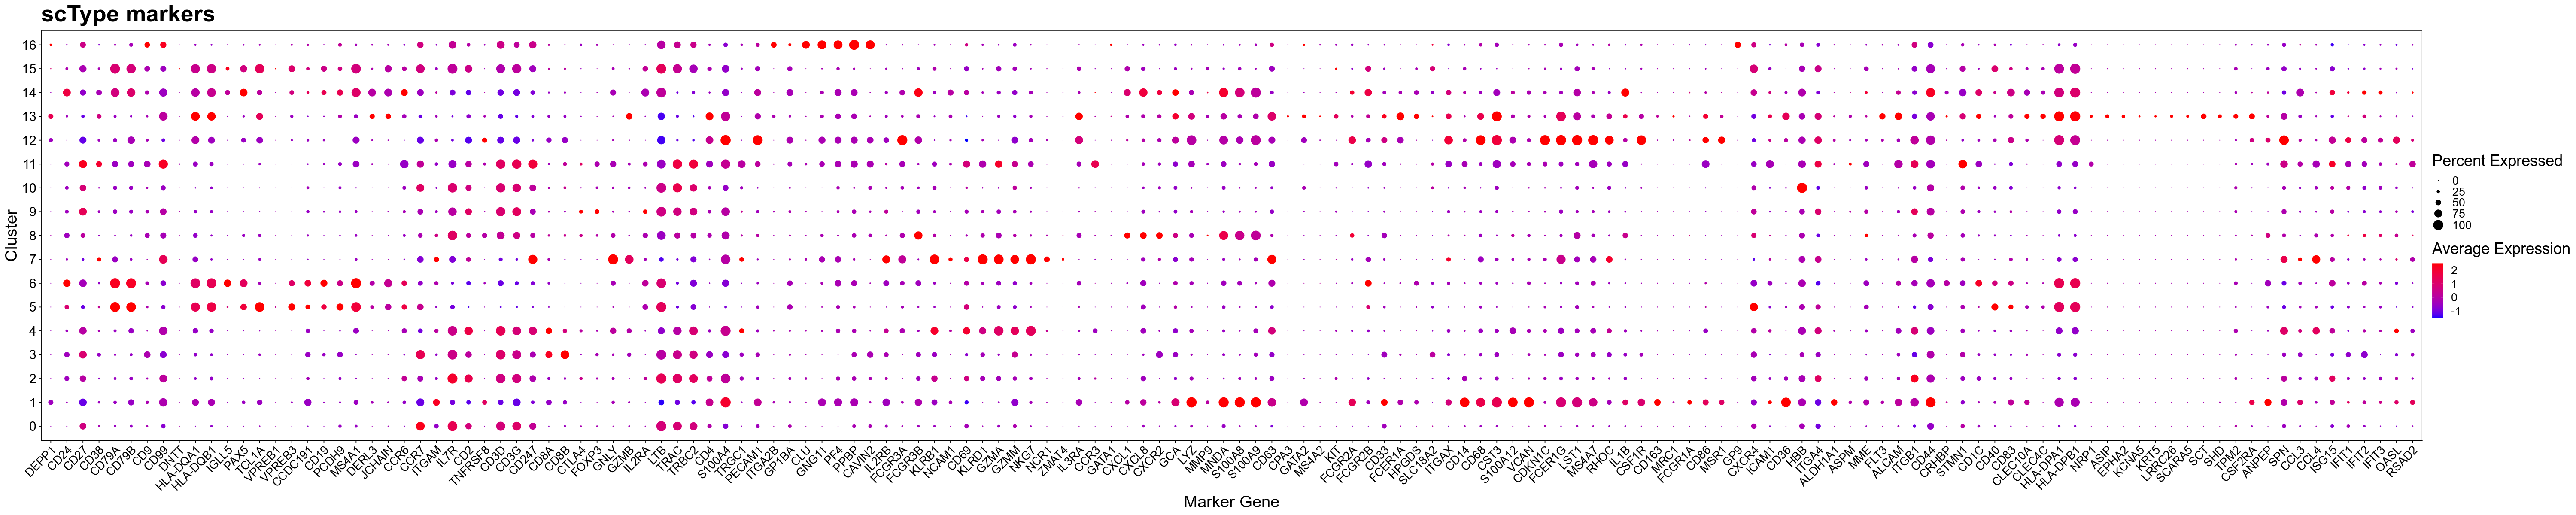

In [18]:
h_ = 10
w_ = 50
options(repr.plot.height=h_, repr.plot.width=w_)

theme = theme(panel.background = element_blank(), 
              panel.border = element_rect(colour = 'black', fill = 'NA'),
         text = element_text(size=28), panel.spacing = unit(1.15, "lines"), 
          axis.title=element_text(size=23), legend.text=element_text(size=16), 
         legend.title=element_text(size=22), axis.text.y = element_text(size = 18), 
              legend.key = element_blank(),
             axis.text.x = element_text(size = 16))
suppressWarnings({
    g<-DotPlot(pbmc.integrated, features = markers.present, cols = c('blue', 'red')) + RotatedAxis()+
    xlab('Marker Gene') + ylab('Cluster') + theme + ggtitle("scType markers")
})

# for (ext in c('.svg', '.png', '.pdf')){ggsave(paste0(results_path, 'figures/', 'marker_subcluster_dotplot', ext), g, 
#                                              height = h_, width = w_)}

g

# Cluster Markers

Identify markers for each cluster to double check that annotated cell types make sense

According to [this study](https://www.nature.com/articles/s41467-021-25960-2), there is not high concordance in methods, but Wilcoxon rank-sum is the most commonly used (and Seurat's default) and you may also want to account for confounders. Thus, I will use the Wilcoxon rank-sum and the logistic regression (as this can account for confounders and seems to be decently performing from the paper). 

LR is also recommended [here](https://bioinformatics.stackexchange.com/questions/6732/how-to-normalise-scrnaseq-data-for-differential-expression-analysis) and [here](https://www.nature.com/articles/s41592-018-0303-9)

Also, [here](https://bmcbioinformatics.biomedcentral.com/articles/10.1186/s12859-019-2599-6#Sec18), MAST isn't super well performing. 

In [26]:

# Wilcoxon
# normalized counts as recommended by 
# https://github.com/satijalab/seurat/issues/2636
# https://github.com/satijalab/seurat/discussions/4000
markers.wilcoxon<-FindAllMarkers(object = pbmc.integrated, assay = 'RNA', only.pos = T, 
               slot = 'data', test.use = 'wilcox', 
               min.pct = 0.25, # stringent since markers
                logfc.threshold = 0.5, 
              )

# logistic regression
# normalized counts as recommended by 
# https://bioinformatics.stackexchange.com/questions/6732/how-to-normalise-scrnaseq-data-for-differential-expression-analysis
# https://www.nature.com/articles/s41592-018-0303-9#Sec2
suppressWarnings({
    suppressMessages({
        markers.lr<-FindAllMarkers(object = pbmc.integrated, assay = 'RNA', only.pos = T, 
                       slot = 'data', test.use = 'LR', latent.vars = 'orig.ident', 
                       min.pct = 0.25, # stringent since markers
                        logfc.threshold = 0.5, 
                      )
    })
})

markers = list('wilcoxon' = markers.wilcoxon, 'LR' = markers.lr)
saveRDS(markers, paste0(data_path, 'interim/cluster_markers.RDS'))

In [69]:
markers<-readRDS(paste0(data_path, 'interim/cluster_markers.RDS'))

Format the marker outputs -- filter for p_adj, more filtering for LFC, and sort by LFC as top markers

Also save to excel sheet

In [70]:
# format markers
marker.excel<-function(marker, de.type){
    markers_workbook<-createWorkbook()
    for (cluster in sort(unique(marker$cluster))){
        de.res.cl<-as.data.frame(marker[marker$cluster == cluster, ])
        rownames(de.res.cl)<-1:dim(de.res.cl)

    #     # make infinites characlers, otherwise writes as NULL
    #     idx_<-as.numeric(rownames(de.res.cl[is.infinite(de.res.cl$LFC), ]))

        addWorksheet(markers_workbook, cluster)
        writeData(markers_workbook, sheet = cluster, x = de.res.cl)
    }
    saveWorkbook(markers_workbook, paste0(data_path, 'interim/', de.type, '_markers.xlsx'))
}

counter<-1
suppressMessages({
    suppressWarnings({
        for (marker in markers){
            de.type<-names(markers)[[counter]]
            marker<-marker[marker$p_val_adj < 0.5,] # threshold on p_adj
            marker<-marker[marker$avg_log2FC > 1.5,] # further threshold on LFC
            marker<-marker[with(marker, order(cluster, -avg_log2FC)), ] # sort by effect size
            
            marker[['scType.annotation']]<-unlist(unname(mapper[marker$cluster]))
            
            marker.excel(marker, de.type) # save to excel file
            
            counter<-counter+1
            markers[[de.type]]<-marker
        }
    })
})

Look at agreement of the filtered markers between the two test types:

In [82]:
table(markers$wilcoxon$cluster) # gene counts per cluster for Wilcoxon


  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16 
 16 765  17  10  97 141 169 189  26  10   3 100 506 350 109  53 157 

In [83]:
table(markers$LR$cluster) # gene counts per cluster for LR


  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16 
 16 765  17  10  97 141 169 189  26  10   3 101 506 350 104  53 173 

In [136]:
jaccard<-function(v1, v2){
    num<-length(intersect(v1, v2))
    denom<-length(union(v1, v2))
    if (denom != 0){
        return(num/denom)
    }else{
        return(NA)
    }
}

jaccard.markers<-list()
for (cluster in sort(unique(md$seurat_clusters))){
    v1<-markers$wilcoxon[markers$wilcoxon$cluster == cluster, 'gene']
    v2<-markers$LR[markers$LR$cluster == cluster, 'gene']
    jaccard.markers[[cluster]]<-jaccard(v1, v2)
}
jaccard.markers.df<-t(data.frame(jaccard.markers))
jaccard.markers.df<-as.data.frame(jaccard.markers.df)
jaccard.markers.df[['Cluster']]<-names(jaccard.markers)
colnames(jaccard.markers.df)<-c('Jaccard.Index', 'Cluster')
jaccard.markers.df

,Jaccard.Index,Cluster
,<dbl>,<chr>
X0,1.0000000,0
X1,1.0000000,1
X2,1.0000000,2
X3,1.0000000,3
X4,1.0000000,4
X5,1.0000000,5
X6,1.0000000,6
X7,1.0000000,7
X8,1.0000000,8


Conclusion: The logistic regression and Wilcoxon test give very consistent DE results for the filtered marker lists. Thus, we should simply proceed with the Wilcoxon test as that is more commonly used. 

In [137]:
saveRDS(pbmc.integrated, 
        file = paste0(data_path, 'interim/pbmc_sctype_annotated.RDS'))